<a href="https://colab.research.google.com/github/brooke57/BrainTumorImageClassification/blob/main/Exploring_the_Black_Box_with_Lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploring the Black Box with Lime**

In [ ]:
# Getting environment info (output cleared to save space, but saved in a file called "Environment_Requirements")
! pip freeze

In [10]:
# Installing Lime
! pip install lime

     |████████████████████████████████| 275 kB 7.6 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=a492d2595a1dca39b54e4a42746af42fd9530464ae1b0f2e78fd13f805ce9faa
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [11]:
# Set random state for numpy operations
from numpy.random import seed
seed(2)
# Set random state for tensorflow operations
from tensorflow.random import set_seed
set_seed(3)
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix
import cv2
import PIL
# Importing libraries for model interpretability 
from lime import lime_image
from skimage.segmentation import mark_boundaries

## **Functions**

In [2]:
# Defining a function that will freeze all layers in a pretrained and original network
# Code structure from https://github.com/learn-co-curriculum/dsc-using-pretrained-networks-codealong
def Freeze_Pretrained_Base(pretrain, model):
    
    '''This function will freeze all layers in a pretrained and original network
      pretrain: refers to any instantiated pretrained network
      model: the name of the model you are adding the pretrained network to
    '''
    pretrain.trainable = False
    for layer in model.layers:
        print(layer.name, layer.trainable)
    print(len(model.trainable_weights))

In [3]:
# Re-freezing everything except for the last layer of the pretrained CNN
# Code structure from https://github.com/learn-co-curriculum/dsc-using-pretrained-networks-codealong
def Unfreeze_Layers(pretrain, layer_list):
    '''This function takes an instantiated pretrained neural network and a list containing layers to be frozen,
    and freezes those layers in the pretrained neural network.
    
    pretrain: refers to the instantiated pretrained neural network
    layer_list: refers to the list of layers to be frozen in the instantiated pretrained neural network.'''

    pretrain.trainable = True
    for layer in  pretrain.layers:
        if layer.name in layer_list:
            layer.trainable = True
        else:
            layer.trainable = False
        
    for layer in pretrain.layers:
        print(layer.name, layer.trainable)
    print(len(pretrain.trainable_weights))

In [4]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [5]:
def print_metrics(saved_model_name, generator, test_or_val):

  superior_model = load_model(saved_model_name)
  final_scores = superior_model.evaluate_generator(generator)
  metrics = ['Loss', 'Accuracy', 'Recall', 'Precision', 'True Positives', 'True Negatives', 'False Positives', 'False Negatives' ]
  
  for i, metric in enumerate(metrics):
    print(test_or_val+' '+ metric + ':', final_scores[i])

In [6]:
# I modified this function slightly from the one found on: 
# https://github.com/austint1121/OES-PneumoniaClassification/blob/main/Final_Notebook.ipynb

def network_matrix(model_scores):
    """
    Plots a confusion matrix using the scores that come from evaluating a 
    neural network model using either testing or validation data
   
  
    Parameters:
    model_scores = load_model('model_name.h5').evaluate_generator(test/val_generator) 
  
    Returns:
    confusion matrix
    """
    tn = np.round((model_scores[5])/(model_scores[5] + model_scores[6]), 2)
    fn = np.round((model_scores[7])/(model_scores[7] + model_scores[4]), 2)
    fp = np.round((model_scores[6])/(model_scores[6] + model_scores[5]), 2)
    tp = np.round((model_scores[4])/(model_scores[4] + model_scores[7]), 2)
    
    
    conf = np.array([[tn, fp], [fn, tp]])
    fig, ax = plt.subplots(figsize=(10, 8))
    heat = sns.heatmap(conf, annot=True, fmt='g', ax=ax )
    heat.set_xticklabels(['Brain Tumor', 'Normal'], fontsize=15)
    heat.set_yticklabels(['Brain Tumor', 'Normal'], fontsize=15)
    plt.ylabel('Predicted Label',fontsize=18)
    plt.xlabel('True Label', fontsize=18)

In [7]:
def print_metrics_confusionmatrix(saved_model_name, generator, test_or_val):

  superior_model = load_model(saved_model_name)
  final_scores = superior_model.evaluate_generator(generator)
  network_matrix(final_scores)
  metrics = ['Loss', 'Accuracy', 'Recall', 'Precision', 'True Positives', 'True Negatives', 'False Positives', 'False Negatives' ]
  
  for i, metric in enumerate(metrics):
    print(test_or_val+' '+ metric + ':', final_scores[i])

In [8]:
def ImageLabelsLime(img, img_idx, exp_num, lab_num, true_label, pred_label):
  
  
    image = img

    explanation_num = exp_num.explain_instance(val_img[img_idx].astype('double'),
                                         best_model.predict, 
                                         top_labels=lab_num,
                                         hide_color=0,
                                         num_samples=1000)
    temp_num, mask_num = explanation_num.get_image_and_mask(explanation_num.top_labels[0],
                                                       positive_only=False, num_features=10,
                                                       hide_rest=False)
    lime_graph = mark_boundaries(temp_num / 2 + 0.5, mask_num)
  
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    
    plt.subplot(1, 2, 2)
    plt.imshow(lime_graph)

    plt.tight_layout()
    plt.show()

    print(f'Correct Label: {true_label}')
    print(f'Predicted Label: {pred_label}')

## **Data Retrieval and Loading**

First, I loaded data that I downloaded from kaggle onto my google drive account. Then I followed instructions from [this blog](https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e) to load the data into this google colab notebook.

In [12]:
# Retrieve the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
#Import libraries
import zipfile
import os
# Load the data
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Brain_MRI_Tumor_Images.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') # Takes out files and puts them into the /tmp folder
zip_ref.close()

In [14]:
# Specify the train and test file paths
base_direc = '/tmp/Brain_MRI_Tumor_Images'
train_direc = os.path.join(base_direc, 'Training')
test_direc = os.path.join(base_direc, 'Testing')

## **Data Preparation**

In [15]:
# Code structure from https://github.com/austint1121/OES-PneumoniaClassification/blob/main/Final_Notebook.ipynb
# Set up ImageDataGenerator
train_imagegen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   zoom_range=([0.6,1]),
                                   rotation_range=10,                           
                                   brightness_range=([0.6, 1.5]),
                                   horizontal_flip=True,
                                   validation_split=0.06) # this will set aside a part of training set for validation data
test_imagegen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   zoom_range=([0.6,1]),
                                   rotation_range=10,
                                   brightness_range=([0.6,1.5]),
                                   horizontal_flip=True)
# Bring the data in
train_generator = train_imagegen.flow_from_directory(
                                    train_direc,
                                    classes={'no_tumor_train':0,
                                            'AllTumorsTrain':1},
                                    target_size=(200,200),
                                    batch_size=2699, # Number of images in training set
                                    seed=42,
                                    class_mode='binary',
                                    subset='training')

test_generator = test_imagegen.flow_from_directory(
                                    test_direc,
                                     classes={'no_tumor_test':0,
                                            'AllTumorsTest':1},
                                    target_size=(200,200),
                                    batch_size=394, # Number of Images in testing set
                                    seed=42,
                                    class_mode='binary')

val_generator = train_imagegen.flow_from_directory(
                                    train_direc,
                                     classes={'no_tumor_train':0,
                                            'AllTumorsTrain':1},
                                    target_size=(200,200),
                                    batch_size=171, # Number of images in validation set
                                    seed=42,
                                    class_mode='binary',
                                    subset='validation')

Found 2699 images belonging to 2 classes.
Found 394 images belonging to 2 classes.
Found 171 images belonging to 2 classes.


In [16]:
# Creating variables to contain image vectors and labels for training images
train_img, train_lab = next(train_generator)

In [17]:
# Creating variables to contain image vectors and labels for testing images
test_img, test_lab = next(test_generator)

In [18]:
# Creating variables to contain image vectors and labels for validation images
val_img, val_lab = next(val_generator)

## **Final Model (Uses the Pre-Trained VGG-19 Weights)**

In [19]:
# Instantiating the pretrained VGG-19 model
from keras.applications.vgg19 import VGG19
cnn_vgg = VGG19(weights='imagenet',
               include_top=False,
               input_shape=(200,200,3))

80150528/80134624 [==============================] - 1s 0us/step


## **Incorporating Class Weights into Pretrained VGG-19 (Final Model)**

In [20]:
# Build first model using pretrained VGG 19 as first layer, and then some dense layers on top
e_w3_b5c1c2 = keras.Sequential()
e_w3_b5c1c2.add(cnn_vgg)
e_w3_b5c1c2.add(layers.Flatten())
e_w3_b5c1c2.add(layers.Dense(128, activation='relu'))
e_w3_b5c1c2.add(layers.Dense(1, activation='sigmoid'))

In [21]:
# Freezing all layers in pretrained VGG-19 network
Freeze_Pretrained_Base(cnn_vgg, e_w3_b5c1c2)

vgg19 False
flatten True
dense True
dense_1 True
4


In [22]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
jan_early_stop2 = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='1_16_2021_best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [23]:
# Incorporating adjusted class weights; compiling and fitting the model
weights3 = {0: 3, # NO TUMOR
          1:1.} # TUMOR 
# there are 6.255 times as many images of MRIs with tumors than without, but acording to the class weight calculation, I should 
# use a number close to 3.63 for the minority class, in this case the no tumor, or "zero" class.


e_w3_b5c1c2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

e_w3_b5c1c2_results = e_w3_b5c1c2.fit(x=train_img, y=train_lab,
                                  batch_size = 32,
                                  class_weight = weights3,
                                  steps_per_epoch=2699//32+1,# number of samples / batch size + 1
                                  epochs=20,
                                  callbacks= jan_early_stop2,
                                  validation_data= (test_img, test_lab),
                                  validation_steps=394//32+1)

Epoch 1/20
85/85 [==============================] - 23s 117ms/step - loss: 0.5428 - acc: 0.8870 - recall: 0.9076 - precision: 0.9591 - true_positives: 2112.0000 - true_negatives: 282.0000 - false_positives: 90.0000 - false_negatives: 215.0000 - val_loss: 0.5628 - val_acc: 0.7766 - val_recall: 0.8028 - val_precision: 0.8821 - val_true_positives: 232.0000 - val_true_negatives: 74.0000 - val_false_positives: 31.0000 - val_false_negatives: 57.0000
Epoch 2/20
85/85 [==============================] - 7s 80ms/step - loss: 0.2031 - acc: 0.9544 - recall: 0.9639 - precision: 0.9829 - true_positives: 2243.0000 - true_negatives: 333.0000 - false_positives: 39.0000 - false_negatives: 84.0000 - val_loss: 0.7183 - val_acc: 0.7030 - val_recall: 0.6125 - val_precision: 0.9725 - val_true_positives: 177.0000 - val_true_negatives: 100.0000 - val_false_positives: 5.0000 - val_false_negatives: 112.0000
Epoch 3/20
85/85 [==============================] - 7s 80ms/step - loss: 0.2078 - acc: 0.9478 - recall: 0.

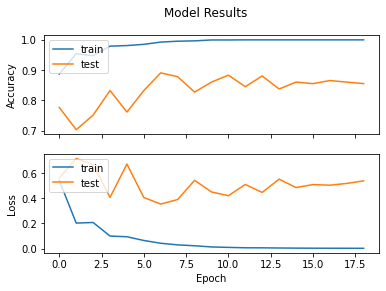

In [24]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(e_w3_b5c1c2_results)

**Analysis of Model**

The epoch with the lowest testing loss has a training accuracy of 98% and a testing accuracy of 91%, with a training loss of 10% and a testing loss of 26%. Testing recall is 89% and testing precision is 98%.

From looking at the training and testing accuracy and loss, it is obvious that this is the most competent model yet. Overfitting has been greatly reduced, testing loss has been reduced considerably, and there is high recall and precision. Now it is time to evaluate the model on the validation hold-out set.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


Val Loss: 0.14596688747406006
Val Accuracy: 0.9532163739204407
Val Recall: 1.0
Val Precision: 0.9487179517745972
Val True Positives: 148.0
Val True Negatives: 15.0
Val False Positives: 8.0
Val False Negatives: 0.0


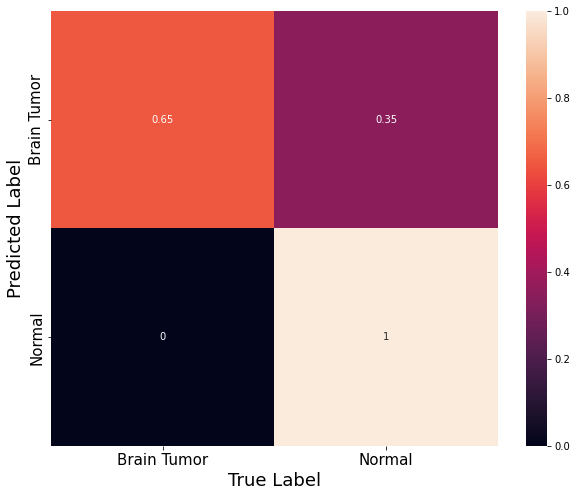

In [25]:
print_metrics_confusionmatrix('1_16_2021_best_model.h5', val_generator, 'Val')

**Analysis of using final model on Validation data**

When the final model was used to evaluate the validation data, it had excellent performance. Validation accuracy is 97%, with a loss of only 7%. The model has 100% recall, which means that it isn't failing to diagnose tumors when they appear in a MRI scan. This was our goal, so it is excellent that recall has been maximized!

## **Overall Conclusions**

Throughout this neural network modeling process, many different iterations were run. In the end, the iteration which yielded the best results was a pretrained VGG-19 network accounting for class weights (giving the minority class of "no tumor" images a weight of three) with a flatten layer and two dense layers on top, with all of the VGG-19 layers frozen. This model iteration had a validation accuracy of 97%, a loss of 7%, recall of 100%, and a precision of 97%. Because recall is 100%, no tumorous scans are slipping through the cracks, which means that patients' tumors will not go undiagnosed. Additionally, because precision is so high as well, the model will identify very few tumor free scans as containing a tumor. These results signify that this would be a powerful, reliable tool for helping to flag scans which have a tumor for further analysis and classification by a physician. In a developing nation with fewer seasoned physicians, who may still be learning to detect and diagnose tumors from an MRI, this would be especially valuable. Additionally, using this model could potentially cut down on the physician time required to analyze patient scans, potentially giving them more time and energy to focus on other patients, thereby improving health outcomes for all. All of these reasons support why this model would be of great benefit for *Doctors without Borders* as they improve the healthcare of developing nations.

## **Digging in to Model Interpretability**

In [27]:
best_model = load_model('/content/1_16_2021_best_model.h5')

In [28]:
# Predictions for Validation data
val_preds_raw = best_model.predict(val_img)
val_preds = (val_preds_raw > 0.5).astype('int32')


In [29]:
val_lab = val_lab.astype('int32')


In [30]:
# getting the indices of the correctly and incorrectly labelled validation images

right = [i for i in range(len(val_img)) if val_preds[i] == val_lab[i]]
wrong = [i for i in range(len(val_img)) if val_preds[i] != val_lab[i]]
wrong

[22, 25, 28, 51, 64, 69, 72, 128, 147, 153, 165]

In [ ]:
tumor_idxs = [i for i in range(len(val_img)) if val_lab[i] == 1]
normal_idxs = [i for i in range(len(val_img)) if val_lab[i] == 0]
tumor_idxs

## **Lime: Normal MRIs labelled as Tumorous**

In [38]:
exp1 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

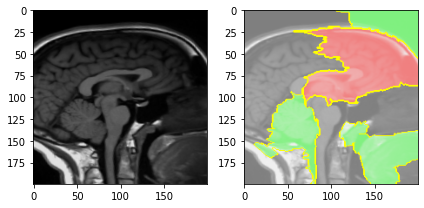

Correct Label: 0
Predicted Label: [1]


In [39]:
ImageLabelsLime(val_img[22], 22, exp1, 3, val_lab[22], val_preds[22])

In [40]:
exp2 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

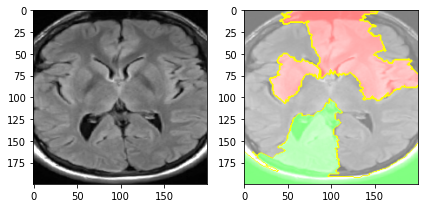

Correct Label: 0
Predicted Label: [1]


In [41]:
ImageLabelsLime(val_img[25], 25, exp2, 3, val_lab[25], val_preds[25])

In [42]:
exp3 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

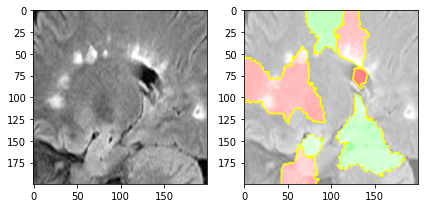

Correct Label: 0
Predicted Label: [1]


In [43]:
ImageLabelsLime(val_img[28], 28, exp3, 3, val_lab[28], val_preds[28])

In [ ]:
exp4 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

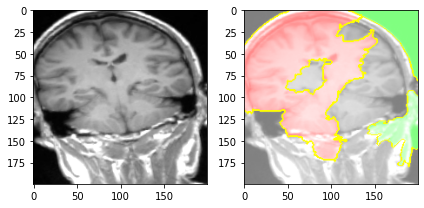

Correct Label: 0
Predicted Label: [0]


In [ ]:
ImageLabelsLime(val_img[51], 51, exp4, 3, val_lab[51], val_preds[51])

In [ ]:
exp5 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

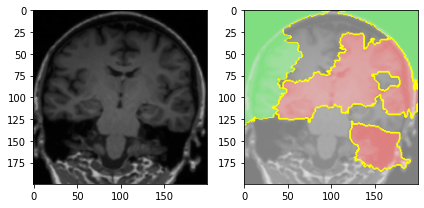

Correct Label: 0
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[64], 64, exp5, 3, val_lab[64], val_preds[64])

In [ ]:
exp6 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

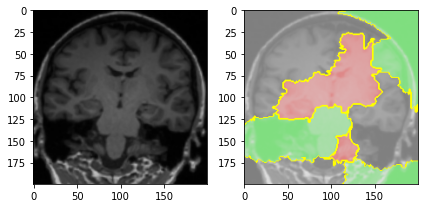

Correct Label: 0
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[64], 64, exp6, 3, val_lab[64], val_preds[64])

In [ ]:
exp7 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

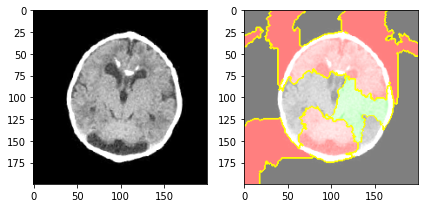

Correct Label: 0
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[69], 69, exp7, 3, val_lab[69], val_preds[69])

In [ ]:
exp8 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

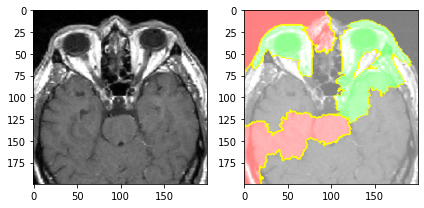

Correct Label: 0
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[72], 72, exp8, 3, val_lab[72], val_preds[72])

In [44]:
exp9 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

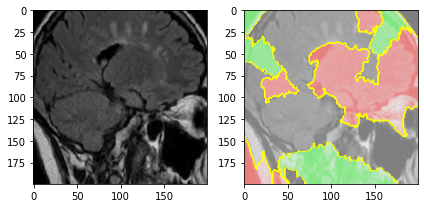

Correct Label: 0
Predicted Label: [1]


In [45]:
ImageLabelsLime(val_img[128], 128, exp9, 3, val_lab[128], val_preds[128])

In [46]:
exp10 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

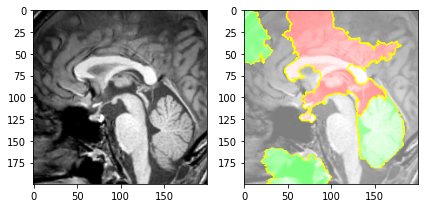

Correct Label: 0
Predicted Label: [1]


In [47]:
ImageLabelsLime(val_img[147], 147, exp10, 3, val_lab[147], val_preds[147])

In [ ]:
exp11 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

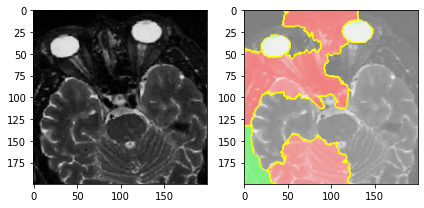

Correct Label: 0
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[153], 153, exp11, 3, val_lab[153], val_preds[153])

In [48]:
exp12 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

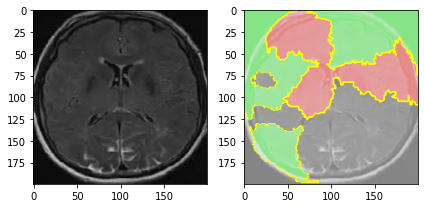

Correct Label: 0
Predicted Label: [1]


In [49]:
ImageLabelsLime(val_img[165], 165, exp12, 3, val_lab[165], val_preds[165])

## **Lime: Images with Tumors**

In [ ]:
exp13 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

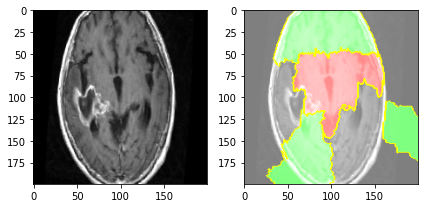

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[0], 0, exp13, 3, val_lab[0], val_preds[0])

In [50]:
exp14 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

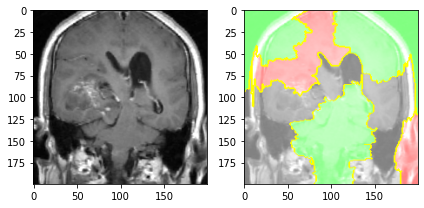

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[1], 1, exp14, 3, val_lab[1], val_preds[1])

In [ ]:
exp15 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

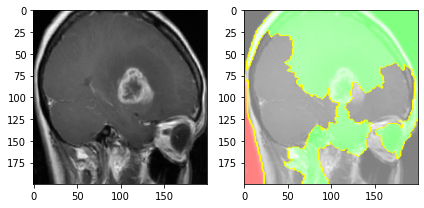

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[30], 30, exp15, 3, val_lab[30], val_preds[30])

In [51]:
exp16 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

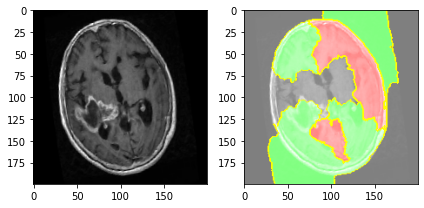

Correct Label: 1
Predicted Label: [1]


In [52]:
ImageLabelsLime(val_img[40], 40, exp16, 3, val_lab[40], val_preds[40])

In [53]:
exp17 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

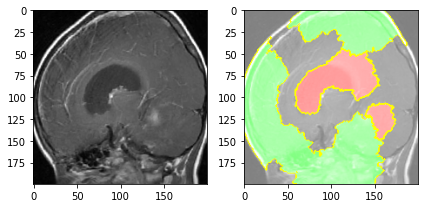

Correct Label: 1
Predicted Label: [1]


In [54]:
ImageLabelsLime(val_img[50], 50, exp17, 3, val_lab[50], val_preds[50])

In [ ]:
exp18 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

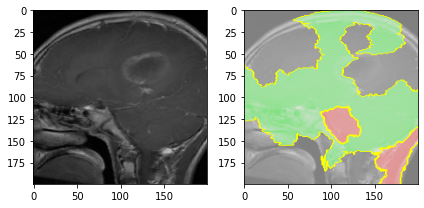

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[62], 62, exp18, 3, val_lab[62], val_preds[62])